# Практические задания к лекции № 4

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

In [45]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

In [5]:
df = pd.read_csv('data.csv')

In [6]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [7]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.rename(columns={"conversion": "target", "offer": "treatment"}, inplace=True)
df.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'zip_code',
       'is_referral', 'channel', 'treatment', 'target'],
      dtype='object')

In [9]:
df.treatment.where(df.treatment != 'No Offer', 0, inplace=True)
df.treatment.where(df.treatment == 0, 1, inplace=True)
df.treatment

0        1
1        0
2        1
3        1
4        1
        ..
63995    1
63996    1
63997    1
63998    1
63999    1
Name: treatment, Length: 64000, dtype: object

In [10]:
df.groupby("treatment")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


In [46]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=28)
df_train.shape, df_test.shape

((44800, 9), (19200, 9))

In [29]:
cat_cols = ['zip_code','channel']

In [47]:
df_train = pd.get_dummies(df_train, columns = cat_cols, drop_first=True)
df_test = pd.get_dummies(df_test, columns = cat_cols, drop_first=True)

провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [48]:
X_train = df_train.drop(['target', 'treatment'], axis=1)
y_train = df_train.loc[:, 'target']
treat_train = df_train.loc[:, 'treatment']

X_val = df_test.drop(['target', 'treatment'], axis=1)
y_val = df_test.loc[:, 'target']
treat_val =  df_test.loc[:, 'treatment']

# X_train_full = df_features.loc[indices_train, :]
# y_train_full = df_train.loc[:, 'target']
# treat_train_full = df_train.loc[:, 'treatment_flg']

# X_test = df_features.loc[indices_test, :]

# cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}

In [19]:
 from sklearn.ensemble import RandomForestClassifier

uplift@30%: 0.0587
uplift@20%: 0.0645
uplift@10%: 0.0749


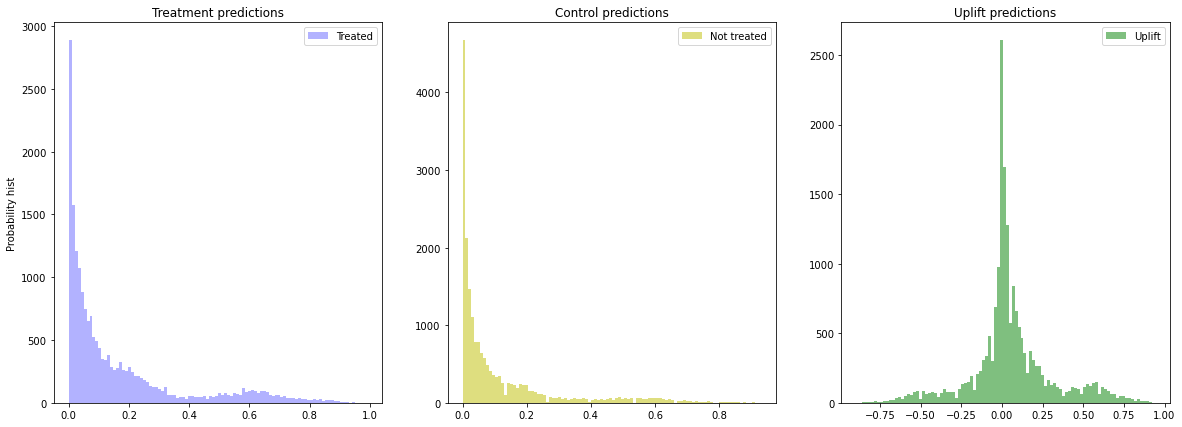

In [49]:
sm = SoloModel(RandomForestClassifier(random_state=28))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')
sm_score_2 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score_2:.4f}')
sm_score_3 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score_3:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_3)
models_results['uplift@20%'].append(sm_score_2)
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [50]:
ct = ClassTransformation(RandomForestClassifier(random_state=28))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {ct_score:.4f}')
ct_score_2 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {ct_score_2:.4f}')
ct_score_3 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {ct_score_3:.4f}')

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_3)
models_results['uplift@20%'].append(ct_score_2)
models_results['uplift@30%'].append(ct_score)

uplift@30%: 0.0582
uplift@20%: 0.0599
uplift@10%: 0.0773


uplift@30%: 0.0615
uplift@20%: 0.0586
uplift@10%: 0.0655


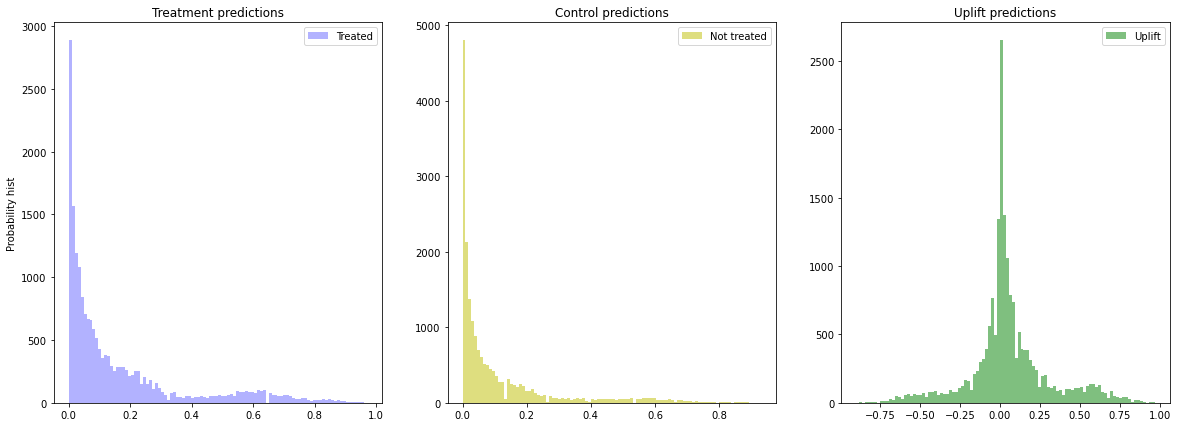

In [51]:
tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(random_state=28), 
    estimator_ctrl=RandomForestClassifier(random_state=28), 
    method='vanilla'
)
tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
print(f'uplift@30%: {tm_score:.4f}')
tm_score_2 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
print(f'uplift@20%: {tm_score_2:.4f}')
tm_score_3 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
print(f'uplift@10%: {tm_score_3:.4f}')

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_3)
models_results['uplift@20%'].append(tm_score_2)
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [52]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@10%,uplift@20%,uplift@30%
2,TwoModels,0.065519,0.058584,0.061539
0,SoloModel,0.074899,0.064465,0.058663
1,ClassTransformation,0.077317,0.059853,0.058197
